# Supervised Representation Learning 

In this tutorial we show how to perform supervised representation learning on CWRU dataset.

In [1]:
%xmode minimal

from pathlib import Path
import os

# os.environ["KERAS_BACKEND"] = "jax"
# os.environ["KERAS_BACKEND"] = "torch"
os.environ["KERAS_BACKEND"] = "tensorflow"

# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # disable GPU devices
os.environ["TFDS_DATA_DIR"] = os.path.expanduser("~/tensorflow_datasets")  # default location of tfds database

# Turn off logging for TF
import logging
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
import tensorflow_datasets as tfds
tf.get_logger().setLevel(logging.ERROR)

# import librosa
# import librosa.display
# from IPython.display import Audio

import numpy as np
from matplotlib import pyplot as plt

# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

import keras
from keras import layers, models, ops, losses, metrics
# from keras.applications import resnet, vgg16

# tf.config.experimental_run_functions_eagerly(True)
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

Exception reporting mode: Minimal


In [2]:
import dpmhm
# dpmhm.datasets.get_dataset_list()

from dpmhm.datasets import preprocessing, feature, utils, transformer, query_parameters

In [3]:
outdir = Path(os.path.expanduser('~/dpmhm/cwru'))
os.makedirs(outdir, exist_ok=True)

## Load the CWRU dataset

We use the CWRU dataset for this tutorial. Suppose it has been correctly installed. We load it using the method `tfds.load()`.

In [4]:
ds0, ds_info = tfds.load(
    'CWRU',
    split='all',
    with_info=True,
)

ds_parms = query_parameters('CWRU')
print(ds_parms)

{'signal': {'DE': 1, 'FE': 1, 'BA': 1}, 'sampling_rate': [12000, 48000], 'keys': {'FaultLocation': {'FanEnd', 'DriveEnd', 'None'}, 'FaultComponent': {'OuterRace12', 'OuterRace6', 'Ball', 'InnerRace', 'OuterRace3', 'None'}, 'FaultSize': {0, 0.007, 0.014, 0.028, 0.021}}, 'filters': {'LoadForce': {0, 1, 2, 3}}, 'type': 'initiated', 'split': ['train']}


### Preprocessing pipeline

Next let's define a preprocessing pipeline consisting of
- selecting data files that contain simultaneously all 3 channels & label ramification
- feature extraction: compute the spectrogram
- sliding window view that yields patches of fixed dimension

In [5]:
rsr = 12000  # resampling rate

compactor = transformer.DatasetCompactor(
    ds0,
    channels=list(ds_parms['signal'].keys()), # select all channels simultaneously
    keys=list(ds_parms['keys'].keys()),    
    resampling_rate=rsr,
    # split=True,  # split multidimensional signals into 1d signals, incompatible with the pretrained VGGish model
)

# Feature extractor
# Spectrogram is computed on a time window of 0.025 second every 0.0125 second, then converted to decibel scale.
tw, hs = 0.025, 0.0125
nf = int(2**(np.ceil(np.log2(rsr*tw))))

_func = lambda x, sr: feature.spectral_features(
    x, sr, 'spectrogram',
    # n_mfcc=256,
    time_window=tw, hop_step=hs, 
    n_fft=nf,
    normalize=True, to_db=True)[0]

extractor = transformer.FeatureExtractor(compactor.dataset, _func)

# A window of width w correspond to w*0.0125 seconds
# window = transformer.WindowSlider(extractor.dataset, window_size=(64,64), hop_size=(32,32))
window = transformer.WindowSlider(extractor.dataset, window_size=80, hop_size=40)  # 1s, full bandwidth

# compactor.dataset.element_spec

Print the dictionary of all labels

In [6]:
labels = list(compactor.full_label_dict.keys())  # need the whole list of labels
print("Number of classes:", len(labels))

compactor.full_label_dict
# compactor.label_dict

Number of classes: 29


{'7f67e45381c3652c': ['FanEnd', 'OuterRace3', '0.014'],
 '8b9e80c02e1fca5b': ['FanEnd', 'OuterRace6', '0.007'],
 'd766ecd2592ce5ec': ['DriveEnd', 'Ball', '0.021'],
 'e27e22f1f5037a20': ['DriveEnd', 'InnerRace', '0.014'],
 '8af14bb8ad669337': ['FanEnd', 'OuterRace12', '0.007'],
 '2533c59036dfe8c8': ['FanEnd', 'InnerRace', '0.007'],
 'd6765bfdf1aca38f': ['DriveEnd', 'Ball', '0.007'],
 'a760eef52ceaa6f9': ['FanEnd', 'OuterRace3', '0.021'],
 'dc8bcb86c369e78b': ['FanEnd', 'InnerRace', '0.021'],
 '9c54396620a4b6a3': ['DriveEnd', 'OuterRace6', '0.021'],
 'b0a92d9d7379d8ce': ['DriveEnd', 'InnerRace', '0.007'],
 '60836667e7ee1dec': ['FanEnd', 'OuterRace3', '0.007'],
 '1c80dbfc87966d6e': ['FanEnd', 'InnerRace', '0.014'],
 '6c2ba36f712d55e4': ['DriveEnd', 'OuterRace6', '0.014'],
 '55503c950ed81973': ['FanEnd', 'Ball', '0.014'],
 'd8957867a1fc0519': ['DriveEnd', 'OuterRace3', '0.007'],
 '605222dceca4b27e': ['FanEnd', 'Ball', '0.021'],
 'd45bbeb3b8a72222': ['DriveEnd', 'OuterRace6', '0.007'],
 'f6

As the last step of preprocessing, apply a preprocessing mapping to transform the dataset to the tuple `(feature, label)` compatible for supervised learning, with the field `feature` in the channel-last format. Finally the preprocessed dataset can be exported to disk for reuse.

In [7]:
preproc = preprocessing.get_mapping_supervised(labels)

ds_window = utils.restore_shape(
    window.dataset.map(preproc, num_parallel_calls=tf.data.AUTOTUNE),
    key=0
)
ds_size = utils.get_dataset_size(ds_window)

import json
with open(outdir/'labels.json', 'w') as fp:
    json.dump(compactor.full_label_dict,fp)
ds_window.save(str(outdir/'cwru'))

### Load the preprocessed dataset

The preprocessed dataset can be loaded from the disk.

In [15]:
ds_window = tf.data.Dataset.load(str(outdir/'cwru'))
ds_size = int(ds_window.cardinality())

with open(outdir/'labels.json', 'r') as fp:
    labels = list(json.load(fp).keys())

In [16]:
print(f"Total number of elements: {ds_window.cardinality()}")
ds_window.element_spec

Total number of elements: 1843


(TensorSpec(shape=(257, 80, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

## Train a ResNet network

Note that the Keras preprocessing model included an outlier class (of label `0`) in the final dataset, we must accordingly increase the number of classes by 1.

In [18]:
# eles = list(ds_window.take(1).as_numpy_iterator())
# input_shape = eles[0][0].shape
input_shape = ds_window.element_spec[0].shape

n_classes = len(labels)+1  # must add one for the outlier class, Keras uses zero-based class labels.
print(f"Number of class: {n_classes}")

splits = {'train':0.7, 'val':0.2, 'test':0.1}
ds_split = utils.split_dataset(ds_window, splits, ds_size=ds_size)

Number of class: 30


Create the training/validation/test set with mini-batches. Notice that the method `.batch()` increases by 1 the rank of the dataset: it is the dimension of the mini-batch.

In [19]:
batch_size = 32

ds_train = ds_split['train'].shuffle(ds_size, reshuffle_each_iteration=True).repeat()\
            .batch(batch_size).prefetch(tf.data.AUTOTUNE)
ds_val = ds_split['val'].batch(batch_size, drop_remainder=True)
ds_test = ds_split['test'].batch(1, drop_remainder=True)

ds_train.element_spec

steps = int(np.floor(ds_size * 0.7/batch_size))

In [ ]:
from keras.applications import ResNet50

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape, classes=n_classes, pooling='avg')

base_model.trainable = False

base_model.summary()

In [21]:
x = layers.Input(input_shape)

# We use a very small classification head and it turns out to be sufficient for the CWRU dataset.
adapt_model = models.Sequential([
    layers.Flatten(name="flatten"),
    layers.Dense(4096, activation="relu", name="fc1"),
    # layers.Dense(4096, activation="relu", name="fc2"),
    layers.Dense(n_classes, activation=None, name="predictions")
])

y = adapt_model(base_model(x))

# Equivalent:
# x = base_model(x)
# x = layers.Flatten(name="flatten")(x)
# x = layers.Dense(4096, activation="relu", name="fc1")(x)
# x = layers.Dense(4096, activation="relu", name="fc2")(x)
# y = layers.Dense(n_classes, activation=None, name="predictions")(x)

In [22]:
model = models.Model(x, y)

from_logits = 'softmax' not in str(model.layers[-1].get_layer('predictions').activation)

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits),
    metrics=['accuracy'],
)

In [23]:
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=10,
    steps_per_epoch=steps,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3),
)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 684ms/step - accuracy: 0.4280 - loss: 2.8005 - val_accuracy: 0.9915 - val_loss: 0.1365
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 28s 700ms/step - accuracy: 0.9775 - loss: 0.1126 - val_accuracy: 1.0000 - val_loss: 0.0333
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 28s 694ms/step - accuracy: 0.9990 - loss: 0.0258 - val_accuracy: 0.9943 - val_loss: 0.0481
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 27s 684ms/step - accuracy: 0.9849 - loss: 0.0533 - val_accuracy: 1.0000 - val_loss: 0.0113
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 27s 687ms/step - accuracy: 1.0000 - loss: 0.0108 - val_accuracy: 1.0000 - val_loss: 0.0065
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 28s 694ms/step - accuracy: 1.0000 - loss: 0.0064 - val_accuracy: 1.0000 - val_loss: 0.0048
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 27s 688ms/step - accuracy: 1.0000 - loss: 0.0052 - val_accuracy: 1.0000 - val_loss: 0.0034
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 28s 695ms/step - accuracy: 1.0000 - loss: 0.0040 - val_accu

In [24]:
model.evaluate(ds_test)

185/185 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 1.0000 - loss: 0.0023


[0.0021293647587299347, 1.0]

### Fine tuning

After training, we can perform several steps of fine tuning with a small learning rate.

In [94]:
base_model.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits),
    metrics=['accuracy'],
)

In [ ]:
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=2,
    steps_per_epoch=steps,    
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3),
)

model.evaluate(ds_test)

# model.save(str(outdir / 'vggish_model_transfer.keras'))

### Visualization of features

1843/1843 ━━━━━━━━━━━━━━━━━━━━ 36s 19ms/step


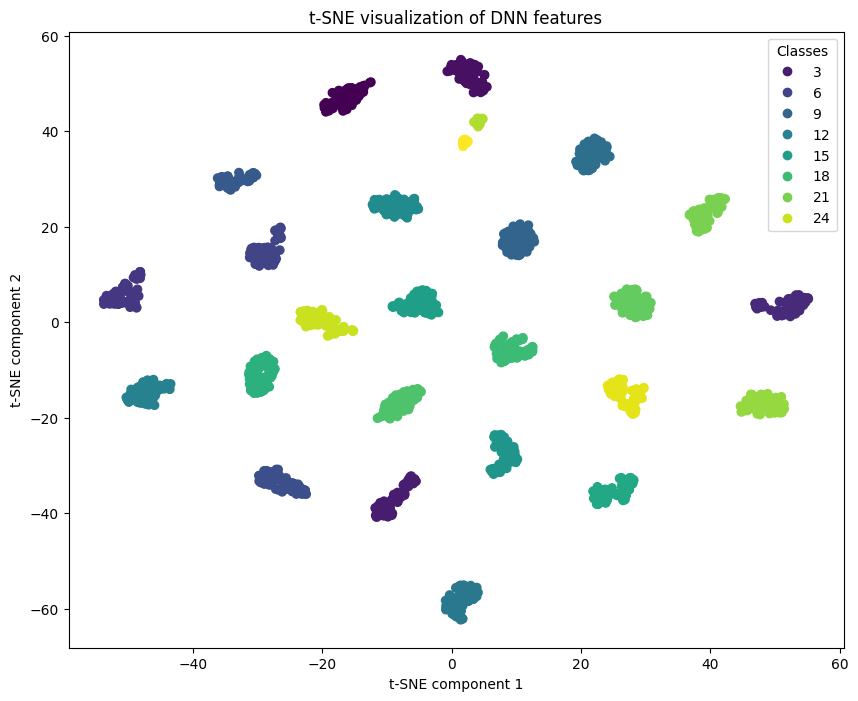

In [25]:
_features = model.predict(ds_window.batch(1))
_labels = list(ds_window.map(lambda x,y: y).as_numpy_iterator())

# _features = model.predict(ds_train)  # Don't use batched data!

from sklearn.manifold import TSNE
# Apply t-SNE to reduce the feature dimensions to 2D
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(_features)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=_labels)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title('t-SNE visualization of DNN features')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.show()

#### Penultimate layer features

In [117]:
_adap_model = models.Model(inputs=adapt_model.inputs, outputs=[adapt_model.layers[1].output])
y = _adap_model(base_model(x))

model_feature = models.Model(x, y)
# model_feature.compile()

# model_feature.summary()
# eles = list(ds_test.take(1))[0]
# model_feature(eles[0]).shape

1843/1843 ━━━━━━━━━━━━━━━━━━━━ 36s 19ms/step


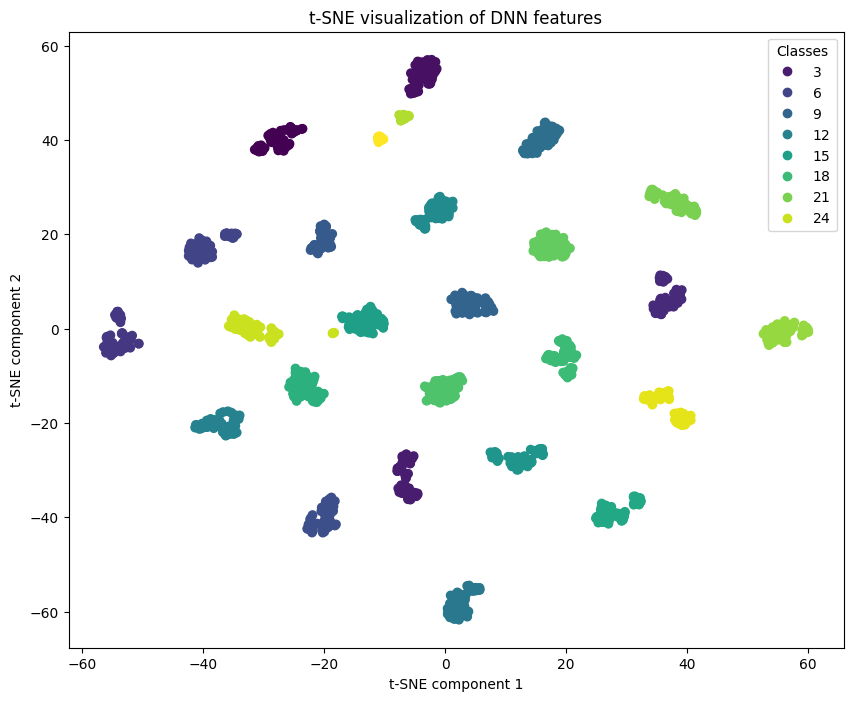

In [118]:
_features = model_feature.predict(ds_window.batch(1))
_labels = list(ds_window.map(lambda x,y: y).as_numpy_iterator())

# _features = model.predict(ds_train)  # Don't use batched data!

from sklearn.manifold import TSNE
# Apply t-SNE to reduce the feature dimensions to 2D
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(_features)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=_labels)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title('t-SNE visualization of DNN features')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.show()

# EOF